In [0]:
#Importación de librerías
try:
  
  #Para usar colab
  from google.colab import drive
  drive.mount('/content/drive')
  
  import numpy as np
  import pandas as pd
  
except:
  
  import numpy as np
  import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline

import seaborn as sns
sns.set()

In [0]:
#Lectura de datos
try:
  #Caso en que se este usando jupyter notebooks
  data_pulsar = pd.read_csv('HTRU_2_con_header.csv')
except:
  #Caso en que se use colab, cambiar directorio de acuerdo al drive
  dir_str ='drive/My Drive/CURSOS - MAESTRIA/APRENDIZAJE AUTOMÁTICO/MACHINE LEARNING - PROYECTO/ML_PULSAR_CLASSIFICATION_PROJECT/PREPROCESAMIENTO DE DATA/HTRU_2_sin_header.csv'
  #Se definen  los headers
  head = ['mean_IP', 'std_IP','kurt_IP','skew_IP','mean_DM', 'std_DM','kurt_DM','skew_DM','is_pulsar']
  #Lectura de la data
  data_pulsar = pd.read_csv(dir_str,header=None, names=head)

# Aplicación de Algoritmos (Data Cruda)

In [0]:
from sklearn.model_selection import train_test_split

#Partición de la data cruda
X = data_pulsar.drop(columns=["is_pulsar"])
y = data_pulsar["is_pulsar"]

X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.15, random_state=0) #random_state = 0, para mantener la particion
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, random_state=0)

In [0]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, confusion_matrix
def eval_model(model, X_val, y_val):
  #Realizando la prediccion del modelo
  y_pred = model.predict(X_val)
  #Calculando el error cuadratico medio
  MSE =mean_squared_error(y_val, y_pred)
  #Generando la matriz de confusion
  conf = confusion_matrix(y_val, y_pred)
  #Calculando las metricas
  accuracy = accuracy_score(y_val, y_pred)
  precision = precision_score(y_val, y_pred)
  recall = recall_score(y_val, y_pred)
  f1score = f1_score(y_val, y_pred)
  
  #Print de las metricas
  print('El MSE para el modelo '+type(model).__name__ +' es: ',MSE)
  print('El accuracy para el modelo '+type(model).__name__ +' es: ',accuracy)
  print('El precision para el modelo '+type(model).__name__ +' es: ',precision)
  print('El recall para el modelo '+type(model).__name__ +' es: ',recall)
  print('El F1-score para el modelo '+type(model).__name__ +' es: ',f1score)
  
  sns.heatmap(conf,annot=True, fmt="d", cmap="coolwarm");
  return None

## SMOTE

In [0]:
#https://imbalanced-learn.readthedocs.io/en/latest/generated/imblearn.over_sampling.SVMSMOTE.html#r88acb9955f91-2
from collections import Counter
from imblearn.over_sampling import SVMSMOTE
smt = SVMSMOTE(random_state=12)
X_sm_train, y_sm_train = smt.fit_resample(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


## **1° Prueba de algoritmo: Random Forest**

El MSE para el modelo RandomForestClassifier es:  0.042392375944791325
El accuracy para el modelo RandomForestClassifier es:  0.9576076240552087
El precision para el modelo RandomForestClassifier es:  0.7038043478260869
El recall para el modelo RandomForestClassifier es:  0.9283154121863799
El F1-score para el modelo RandomForestClassifier es:  0.8006182380216383


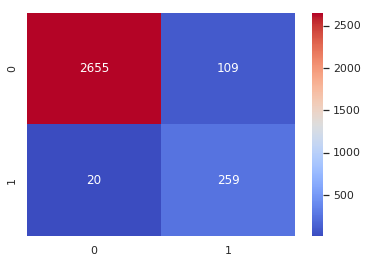

In [0]:
from sklearn.ensemble import RandomForestClassifier

RF_model = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
RF_model.fit(X_sm_train, y_sm_train)

eval_model(RF_model, X_val, y_val)

### Interpretación del modelo

In [0]:
RF_model.feature_importances_

array([0.17339681, 0.00409454, 0.40618922, 0.03608292, 0.10391134,
       0.18573416, 0.03375542, 0.0568356 ])

In [0]:
imp = pd.DataFrame({'cols':X_val.columns, 'imp':RF_model.feature_importances_}).sort_values('imp', ascending=False)
imp.style.bar()

,cols,imp
2,kurt_IP,0.406189
5,std_DM,0.185734
0,mean_IP,0.173397
4,mean_DM,0.103911
7,skew_DM,0.0568356
3,skew_IP,0.0360829
6,kurt_DM,0.0337554
1,std_IP,0.00409454


In [0]:
from sklearn.model_selection import GridSearchCV

## **2° Prueba de algoritmo: SVM**

El MSE para el modelo SVC es:  0.09004272099901413
El accuracy para el modelo SVC es:  0.9099572790009859
El precision para el modelo SVC es:  0.5454545454545454
El recall para el modelo SVC es:  0.10752688172043011
El F1-score para el modelo SVC es:  0.17964071856287425


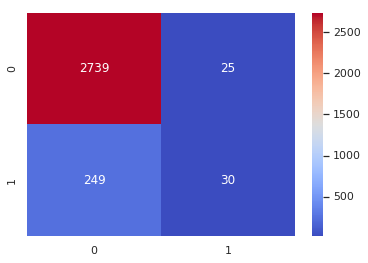

In [0]:
from sklearn.svm import SVC

SVM_model = SVC(gamma='auto',kernel='rbf')
SVM_model.fit(X_sm_train, y_sm_train) 

eval_model(SVM_model, X_val, y_val)

**Grid Search CV**

In [0]:
from sklearn.model_selection import GridSearchCV

parametrosSVM = {
    'C':[100],
    'gamma' : ['auto'],
    'kernel':['rbf']
}

clf = GridSearchCV(
    estimator =SVM_model,
    param_grid = parametrosSVM,    
    cv=10,
    n_jobs=-1
) 

clf.fit(X_train,y_train)



Mejores parámetros obtenidos: {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}



In [130]:
print ("Mejores parámetros obtenidos:", clf.best_params_)
print ()

Mejores parámetros obtenidos: {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}



El MSE para el modelo SVC es:  0.09004272099901413
El accuracy para el modelo SVC es:  0.9099572790009859
El precision para el modelo SVC es:  0.5714285714285714
El recall para el modelo SVC es:  0.07168458781362007
El F1-score para el modelo SVC es:  0.1273885350318471


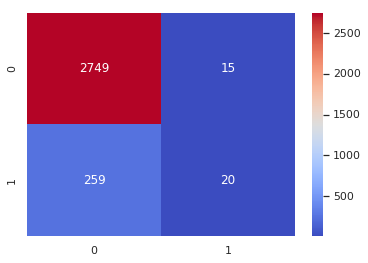

In [131]:
eval_model(clf.best_estimator_, X_val, y_val)

## **3° Prueba de algoritmo: KNN**

El MSE para el modelo KNeighborsClassifier es:  0.04732172198488334
El accuracy para el modelo KNeighborsClassifier es:  0.9526782780151166
El precision para el modelo KNeighborsClassifier es:  0.6839237057220708
El recall para el modelo KNeighborsClassifier es:  0.899641577060932
El F1-score para el modelo KNeighborsClassifier es:  0.7770897832817337


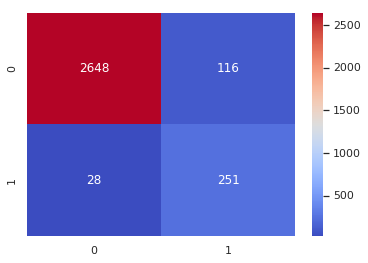

In [0]:
from sklearn.neighbors import KNeighborsClassifier 

KNN_model = KNeighborsClassifier(n_neighbors=5)
KNN_model.fit(X_sm_train, y_sm_train) 

eval_model(KNN_model, X_val, y_val)

## 4° Prueba de algoritmo: ANN -Multi-layer Perceptron


El MSE para el modelo MLPClassifier es:  0.03614853762734144
El accuracy para el modelo MLPClassifier es:  0.9638514623726585
El precision para el modelo MLPClassifier es:  0.7463556851311953
El recall para el modelo MLPClassifier es:  0.9175627240143369
El F1-score para el modelo MLPClassifier es:  0.8231511254019291


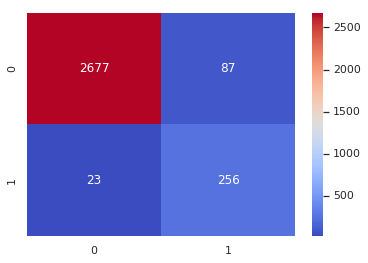

In [0]:
from sklearn.neural_network import MLPClassifier

NN_model = MLPClassifier()
NN_model.fit(X_sm_train, y_sm_train) 

eval_model(NN_model, X_val, y_val)